# cycleGANs for STEM images

In this section, we'll train a GAN to noise up a simulated image to look like an experimental image

## Imports

In [1]:
from make_dataset import parse_and_save_dir, load_train_data
from models import unet_generator, discriminator, generator_resnet
import tensorflow as tf
from plotting_tools import *
import pickle
import time
from glob import glob
from IPython.display import clear_output

## Loading in Images
First, we load in a simulated image and experimental image, and cut them into 256x256 chunks. We then store the images in folders.

In [2]:
parent_dir = "C:/Users/abidk/Dropbox/Development/programs/stem-learning/code/cycle_gan/"
exp_dir_raw = parent_dir + "data/RR/"
sim_dir_raw = parent_dir + "data/sim_107/"

exp_dir = parent_dir + "data/exp_256/"
sim_dir = parent_dir + "data/sim_256/"

fine_size, stride = 256, 256

In [3]:
#parse_and_save_dir(exp_dir_raw, exp_dir, fine_size, stride)
#parse_and_save_dir(sim_dir_raw, sim_dir, fine_size, stride)

## Construct Generator and Discriminator

In [4]:
#generator_exp = unet_generator(1, "instancenorm")
#generator_sim = unet_generator(1, "instancenorm")

generator_exp = generator_resnet(64)
generator_sim = generator_resnet(64)

discriminator_sim = discriminator("instancenorm", target=False)
discriminator_exp = discriminator("instancenorm", target=False)

In [5]:
generator_exp_optimizer = tf.keras.optimizers.Adam(2e-4)
generator_sim_optimizer = tf.keras.optimizers.Adam(2e-4)

discriminator_sim_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_exp_optimizer = tf.keras.optimizers.Adam(2e-4)

## Loss Functions and Accuracies

In [6]:
LAMBDA = 100

#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, fake):
    real_loss = loss_obj( tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss * 0.5

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def calc_cycle_loss(real_image, cycled_image):
    diff = tf.abs(real_image - cycled_image)
    L1_norm = tf.reduce_mean(diff)
    return L1_norm

## Checkpoints

In [7]:
identifier = "20210914_resunet_trunc_norm"
checkpoint_path = parent_dir + "checkpoint_{}".format(identifier)
log_data_fn = "data_{}.p".format(identifier)

ckpt = tf.train.Checkpoint(generator_exp=generator_exp,
                           generator_sim=generator_sim,
                           discriminator_sim=discriminator_sim,
                           discriminator_exp=discriminator_exp,
                           generator_exp_optimizer=generator_exp_optimizer,
                           generator_sim_optimizer=generator_sim_optimizer,
                           discriminator_sim_optimizer=discriminator_sim_optimizer,
                           discriminator_exp_optimizer=discriminator_exp_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    #cpath = ckpt_manager.checkpoints[-2]
    cpath = ckpt_manager.latest_checkpoint
    print("loading checkpoint ", cpath)
    ckpt.restore(cpath)
    print ('Latest checkpoint restored!')

## Training Functions

In [8]:
@tf.function
def train_generators(real_sim, real_exp, train=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_exp   = generator_exp(real_sim, training=train)
    cycled_sim = generator_sim(fake_exp, training=train)

    fake_sim   = generator_sim(real_exp, training=train)
    cycled_exp = generator_exp(fake_sim, training=train)

    disc_fake_sim = discriminator_sim(fake_sim, training=False)
    disc_fake_exp = discriminator_exp(fake_exp, training=False)

    # calculate the loss
    gen_exp_loss = generator_loss(disc_fake_exp)
    gen_sim_loss = generator_loss(disc_fake_sim)

    cycle_exp_loss = calc_cycle_loss(real_exp, cycled_exp)
    cycle_sim_loss = calc_cycle_loss(real_sim, cycled_sim)
    total_cycle_loss = LAMBDA*(cycle_exp_loss + cycle_sim_loss)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_exp_loss = gen_exp_loss + total_cycle_loss
    total_gen_sim_loss = gen_sim_loss + total_cycle_loss
  
  if train:
    # Calculate the gradients for generator and discriminator
    generator_exp_gradients = tape.gradient(total_gen_exp_loss, generator_exp.trainable_variables)
    generator_sim_gradients = tape.gradient(total_gen_sim_loss, generator_sim.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_exp_optimizer.apply_gradients(zip(generator_exp_gradients, generator_exp.trainable_variables))
    generator_sim_optimizer.apply_gradients(zip(generator_sim_gradients, generator_sim.trainable_variables))

  return cycle_exp_loss, cycle_sim_loss, gen_exp_loss, gen_sim_loss

@tf.function
def train_discriminators(real_sim, real_exp, train=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_exp   = generator_exp(real_sim, training=train)
    fake_sim   = generator_sim(real_exp, training=train)

    disc_real_sim = discriminator_sim(real_sim, training=train)
    disc_fake_sim = discriminator_sim(fake_sim, training=train)

    disc_real_exp = discriminator_exp(real_exp, training=train)
    disc_fake_exp = discriminator_exp(fake_exp, training=train)
    
    # Calculate loss
    disc_sim_loss = discriminator_loss(disc_real_sim, disc_fake_sim)
    disc_exp_loss = discriminator_loss(disc_real_exp, disc_fake_exp)
  
  if train:
    # Calculate the gradients for generator and discriminator
    discriminator_sim_gradients = tape.gradient(disc_sim_loss, discriminator_sim.trainable_variables)
    discriminator_exp_gradients = tape.gradient(disc_exp_loss, discriminator_exp.trainable_variables)
  
    # Apply the gradients to the optimizer
    discriminator_sim_optimizer.apply_gradients(zip(discriminator_sim_gradients, discriminator_sim.trainable_variables))
    discriminator_exp_optimizer.apply_gradients(zip(discriminator_exp_gradients, discriminator_exp.trainable_variables))
  return disc_sim_loss, disc_exp_loss

## Training

In [9]:
gen_exp_losses,   gen_sim_losses   = [], []
disc_exp_losses,  disc_sim_losses  = [], []
cycle_exp_losses, cycle_sim_losses = [], []
disc_exp_accs,    disc_sim_accs    = [], []
epoch = 0
batch_size = 8
train_size = 10000

try:
    (gen_exp_losses,  gen_sim_losses, 
    disc_sim_losses,  disc_exp_losses, 
    cycle_exp_losses, cycle_sim_losses,
    disc_sim_accs,    disc_exp_accs,      epoch) = pickle.load(open(log_data_fn, "rb" ))
    print("loading at epoch ", epoch)
except Exception as e:
    print(e)
    pass
last=None

[Errno 2] No such file or directory: 'data_20210914_resunet_trunc_norm.p'


In [10]:
while epoch < 200:
    start = time.time()
    if epoch > 100:
        lr = 2e-4*(1 - (epoch-100 + 1)/100)
        print(epoch, lr)
        generator_exp_optimizer.lr.assign(lr)
        generator_sim_optimizer.lr.assign(lr)
        discriminator_sim_optimizer.lr.assign(lr)
        discriminator_exp_optimizer.lr.assign(lr)

    data_sim = glob('{}/*.*'.format(sim_dir))
    data_exp = glob('{}/*.*'.format(exp_dir))
    np.random.shuffle(data_sim)
    np.random.shuffle(data_exp)
    batch_idxs = min(min(len(data_sim), len(data_exp)), train_size) // batch_size

    for idx in range(0, batch_idxs):
        batch_start =  time.time()
        sim_fn_list = data_sim[idx*batch_size:(idx + 1)*batch_size]
        exp_fn_list = data_exp[idx*batch_size:(idx + 1)*batch_size]

        real_sim = np.array([load_train_data(fn) for fn in sim_fn_list]).astype(np.float32)
        real_exp = np.array([load_train_data(fn) for fn in exp_fn_list]).astype(np.float32)

        dis_losses = train_discriminators(real_sim, real_exp, train=True)
        gen_losses = train_generators(real_sim, real_exp, train=True)

        print("[{}/{}]: {}".format(idx, batch_idxs, (time.time()-batch_start)/batch_size))

    clear_output(wait=True)

    cycle_exp_loss, cycle_sim_loss, gen_exp_loss, gen_sim_loss = gen_losses
    disc_sim_loss, disc_exp_loss = dis_losses

    # Calculate accuracy
    fake_sim = generator_sim(real_exp, training=False)
    fake_exp = generator_exp(real_sim, training=False)

    disc_sim_acc = get_discriminator_acc(discriminator_sim, real_sim, fake_sim, threshold=0.5)
    disc_exp_acc = get_discriminator_acc(discriminator_exp, real_exp, fake_exp, threshold=0.5)

    gen_exp_losses.append(gen_exp_loss)
    gen_sim_losses.append(gen_sim_loss)
    cycle_exp_losses.append(cycle_exp_loss)
    cycle_sim_losses.append(cycle_sim_loss)
    disc_sim_losses.append(disc_sim_loss)
    disc_exp_losses.append(disc_exp_loss)
    disc_sim_accs.append(disc_sim_acc)
    disc_exp_accs.append(disc_exp_acc)
    epoch += 1

    sample_sim = real_sim[0].reshape([1,fine_size,fine_size,1])
    sample_exp = real_exp[0].reshape([1,fine_size,fine_size,1])
    generate_images(generator_exp, generator_sim, sample_sim)
    generate_images(generator_sim, generator_exp, sample_exp)
    generate_losses(gen_exp_losses,   gen_sim_losses,
                    cycle_exp_losses, cycle_sim_losses,
                    disc_sim_losses,  disc_exp_losses,   epoch, last=last)
    generate_accuracies(disc_sim_accs, disc_exp_accs, epoch, last=last)

    if (epoch) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path))
        pickle.dump( (
                        gen_exp_losses,  gen_sim_losses, 
                        disc_sim_losses,  disc_exp_losses, 
                        cycle_exp_losses, cycle_sim_losses,
                        disc_sim_accs,    disc_exp_accs, epoch-1
                     ),
                     open( log_data_fn, "wb" ) )

    print ('Time taken for epoch {} is {} sec\n'.format(epoch, time.time()-start))

ValueError: in user code:

    C:\Users\abidk\AppData\Local\Temp/ipykernel_10388/1654764623.py:53 train_discriminators  *
        disc_fake_sim = discriminator_sim(fake_sim, training=train)
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py:1037 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\keras\layers\convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\nn_ops.py:1131 convolution_v2
        return convolution_internal(
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\nn_ops.py:1261 convolution_internal
        return op(
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\nn_ops.py:2715 _conv2d_expanded_batch
        return gen_nn_ops.conv2d(
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\gen_nn_ops.py:968 conv2d
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\abidk\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 4 from 3 for '{{node model_2/conv2d_52/Conv2D_1}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](model_2/zero_padding2d_1/Pad_1, model_2/conv2d_52/Conv2D_1/ReadVariableOp)' with input shapes: [8,3,3,512], [4,4,512,1].


In [ ]:
real_exp.shape

(8, 256, 256, 1)

In [ ]:
import numpy as np
import os
from params import *
from post_process import *
import shutil
from time import sleep

bkg_file = incostem_dir + "bkg_images/Bkg_stack_107.tif"

cur_dir = os.getcwd()
os.chdir(incostem_dir)
### generate param and xyz files ####
generate_files(sample_param_dic, EM_param_dic, 1)
#####################################

### use incostem to create images ###
bat_file = [f for f in os.listdir() if ".bat" in f][0]
with open(bat_file, 'r') as bat:
    for cmd in bat:
        print(cmd)
        if os.system(cmd):
            print("ERROR EXECUTING COMMAND: ", cmd)


[os.remove(f) for f in os.listdir() if ".xyz" in f or ".param" in f or ".bat" in f]
#####################################

### do postprocessing
Mypostprocess = post_process(image_path=incostem_dir,file_num=1, defect_list = defect_list)
Mypostprocess.read_image_and_label()
Mypostprocess.save_as_image(simulated_image_dir)


Mypostprocess = post_process(image_path=incostem_dir,file_num=1, defect_list = defect_list)
Mypostprocess.read_image_and_label()
Mypostprocess.experimentalize(bkg_file)
Mypostprocess.save_as_image(simulated_image_dir + "manual/")

os.chdir(cur_dir)

./incostem<WSe_incostem_64_37_1_0.param 

./incostem<WSe_metal_Doped_incostem_64_37_1_0.param 

./incostem<WSe_cmetal_vacancy_incostem_64_37_1_0.param 

./incostem<WSe_2Doped_incostem_64_37_1_0.param 

./incostem<WSe_1Doped_incostem_64_37_1_0.param 

./incostem<WSe_1vacancy_incostem_64_37_1_0.param 

./incostem<WSe_2vacancy_incostem_64_37_1_0.param 



processing data
loading model
strides: (32, 32)
predicting data
stitching data


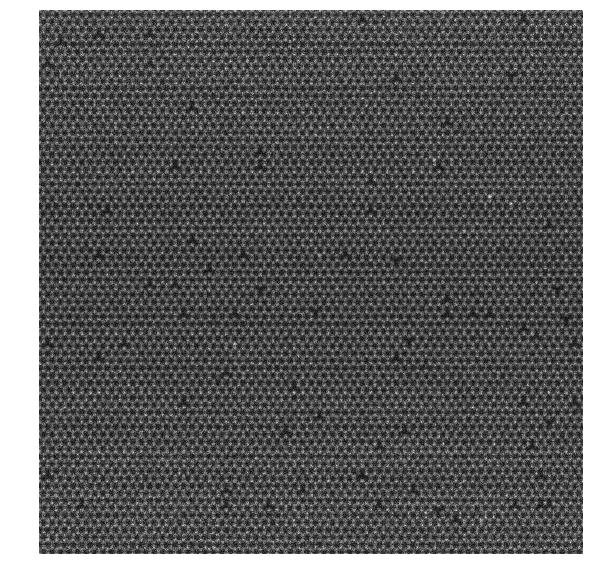

saving data


In [ ]:
sys.path.insert(0,"3_evaluate")
from evaluate import generate_image
input_file = "{}/image0/input.tiff".format(simulated_image_dir)
gen_exp_img = generate_image(generator_exp, input_file,(lx,ly) , stride=(32,32), avg=True, \
        plot=True, save_data=True, save_dir='./',fname='generated_input.tiff')

In [ ]:
image_fn = "/home/skhan/stem_learning/data/WSe/raw_experimental/RR_1615 STEM 4.60 Mx HAADF_34.0pA_1024px_2.0us_Raw_Stack_16bit.tif"
